In [28]:
import os
import numpy as np

# --- Execution ---
#input_img_path = 'output_dither.png' # The "clean" image
input_img_path = '../posters/IMG_2075-Enhanced-NR.png' # The "clean" image
power_levels = np.array([0.0, 0, 0, 1.0], dtype=np.float32)
target_image_dpi = 260 # Set this to the DPI of your input_img_path
TARGET_LONGEST_EDGE_MM = 270  # Set the desired length of the longest side in mm
runout_mm = 2.0

percentile = 99
pre_adj_strength = 0.5
pre_gamma = 1.0
lut_file = 'uv_laser_correction_inverted.csv'


BLUE_NOISE_PATH = os.path.join('..', 'bluenoise', '128_128', 'LDR_LLL1_0.png')
kernel_file = 'averaged_deconvolution_kernel.npy'
kernel_source_dpi = 1200

# --- Dither ---
# Adjust these paths as needed
INPUT_IMAGE_PATH = "corrected_pre_dither.png"
post_img_path = 'post_dither.png'


In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def apply_dot_gain(image_path, kernel_path, source_dpi=1200, target_dpi=300):
    # 1. Load the target image and the kernel
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError("Target image not found.")
    
    scale_factor_in = source_dpi / target_dpi
    img_newx =  int(round(img.shape[1] * scale_factor_in))
    img_newy =  int(round(img.shape[0] * scale_factor_in))

    img_scaled = cv2.resize(img, (img_newx, img_newy), interpolation=cv2.INTER_CUBIC)
    
    # Load the 1200dpi kernel we saved earlier
    kernel_1200 = np.load(kernel_path)
    
    # # 2. Scale the kernel to match the target image DPI
    # # If target is 300dpi and source is 1200dpi, scale is 0.25
    # scale_factor = target_dpi / source_dpi
    # new_size = int(round(kernel_1200.shape[0] * scale_factor))
    
    # # Ensure size is odd for a centered kernel
    # if new_size % 2 == 0:
    #     new_size += 1
        
    # # Resize the kernel using inter-area interpolation (best for shrinking)
    # kernel_scaled = cv2.resize(kernel_1200, (new_size, new_size), interpolation=cv2.INTER_AREA)
    
    # # IMPORTANT: Re-normalize after resizing so the sum remains 1.0
    # # This ensures the image doesn't get brighter or darker
    # kernel_scaled /= kernel_scaled.sum()
    
    # 3. Apply the simulation
    # To simulate ink spreading (dot gain), we convolve the image.
    # filter2D handles multi-channel images (BGR) automatically.
    simulated_img = cv2.filter2D(img_scaled, -1, kernel_1200)

    simulated_img = cv2.resize(simulated_img,(int(round(img.shape[1])), int(round(img.shape[0]))), interpolation=cv2.INTER_AREA)

    
    # 4. Optional: Non-linear Dot Gain Adjustment
    # Physical dot gain is often non-linear (darker areas spread more).
    # You can simulate this by slightly darkening the midtones (gamma correction)
    # gamma = 1.1 
    # simulated_img = np.array(255 * (simulated_img / 255) ** gamma, dtype='uint8')

    return img, simulated_img, kernel_1200

# original, simulated, final_kernel = apply_dot_gain(
#     input_img_path, 
#     kernel_file, 
#     source_dpi=1200, 
#     target_dpi=target_image_dpi
# )

# --- Visualization ---
# plt.figure(figsize=(15, 7))

# plt.subplot(1, 3, 1)
# plt.title(f"Original Digital Image ({target_image_dpi} DPI)")
# plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
# plt.axis('off')

# plt.subplot(1, 3, 2)
# plt.title("Simulated Printed Dot Gain")
# plt.imshow(cv2.cvtColor(simulated, cv2.COLOR_BGR2RGB))
# plt.axis('off')

# plt.subplot(1, 3, 3)
# plt.title(f"Rescaled Kernel ({final_kernel.shape[0]}px)")
# plt.imshow(final_kernel, cmap='viridis')

# plt.tight_layout()
# plt.show()

# Save the result
#cv2.imwrite('simulated_print_output.png', simulated)

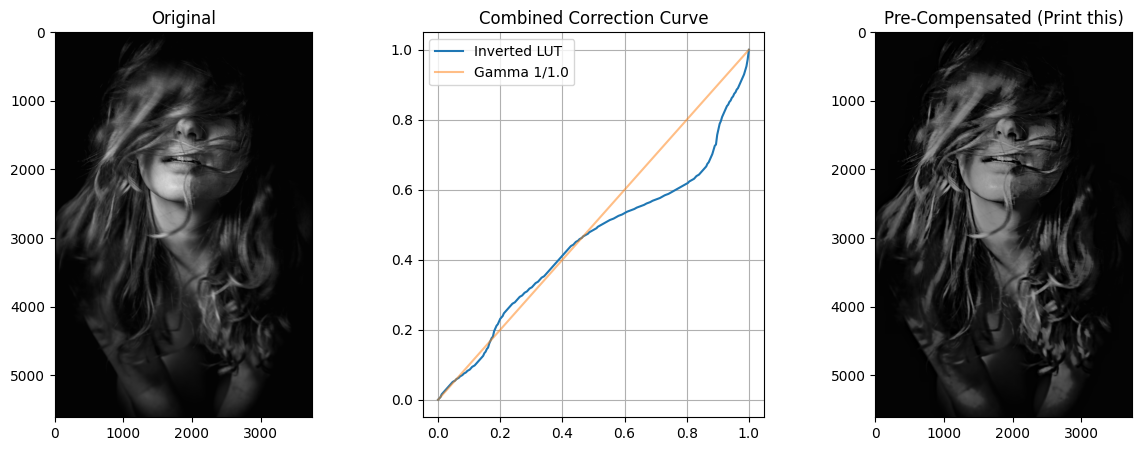

True

In [30]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def apply_cyanotype_correction(image_path, kernel_path, lut_csv_path, target_gamma=2.2, strength=1.0):
    # 1. Load Image
    img = cv2.imread(image_path)
    if img is None: raise FileNotFoundError("Image not found")
    img = img.astype(np.float32) / 255.0  # Work in 0.0-1.0 range for gamma

    # 2. Step 1: Gamma Pre-Compensation
    # If paper darkens with gamma 2.2, we lighten with 1/2.2
    gamma_corrected = np.power(img, 1.0 / target_gamma)

    # 3. Step 2: LUT Compensation (from your CSV)
    # We load the CSV and find the inverse mapping
    df = pd.read_csv(lut_csv_path).sort_values(by='Input')
    
    # Check if CSV is Density (0=White) or Brightness (255=White)
    # If the end of the curve is lower than the start, it's Density. Flip it.
    if df['Output'].iloc[-1] < df['Output'].iloc[0]:
        df['Output'] = 255 - df['Output']

    # Create the inverse LUT: "What digital value gives this paper output?"
    all_vals = np.linspace(0, 1, 256)
    # Interpolate using normalized 0-1 values
    xp = df['Output'].values / 255.0
    fp = df['Input'].values / 255.0
    
    # Generate the compensation curve
    inv_lut_vals = np.interp(all_vals, xp, fp)
    
    # Apply LUT to the gamma-corrected image
    # We use a simple interpolation to apply the curve to the float image
    final_toned = np.interp(gamma_corrected, all_vals, inv_lut_vals)

    # 4. Step 3: Spatial Deconvolution (Sharpening)
    # Use your 1200dpi kernel to counteract physical bleeding
    kernel_1200 = np.load(kernel_path)

    scale_factor = 1200 / target_image_dpi
    new_size = int(round(kernel_1200.shape[0] * scale_factor))
    if new_size % 2 == 0: new_size += 1
    
    kernel_small = cv2.resize(kernel_1200, (new_size, new_size), interpolation=cv2.INTER_AREA)
    kernel_small /= kernel_small.sum()

    # High-pass sharpening logic
    blurred = cv2.filter2D(final_toned, -1, kernel_small)
    sharpened = final_toned + (final_toned - blurred) * strength
    
    # 5. Final Output
    final_img = np.clip(sharpened * 255.0, 0, 255).astype(np.uint8)

    # --- Visualization ---
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_BGR2RGB))
    
    plt.subplot(1, 3, 2)
    plt.title("Combined Correction Curve")
    plt.plot(all_vals, inv_lut_vals, label="Inverted LUT")
    plt.plot(all_vals, np.power(all_vals, 1/target_gamma), label=f"Gamma 1/{target_gamma}", alpha=0.5)
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.title("Pre-Compensated (Print this)")
    plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))
    plt.show()

    return final_img

# --- EXECUTION ---
corrected = apply_cyanotype_correction(
    image_path=input_img_path,
    kernel_path=kernel_file,
    lut_csv_path=lut_file,
    target_gamma=pre_gamma, # Standard cyanotype contrast
    strength=pre_adj_strength      # Adjust sharpening strength (0.0 to 1.5)
)

cv2.imwrite('corrected_pre_dither.png', corrected)


Loading image: corrected_pre_dither.png
Image Size: (2763, 1842)
Loading noise: ..\bluenoise\128_128\LDR_LLL1_0.png


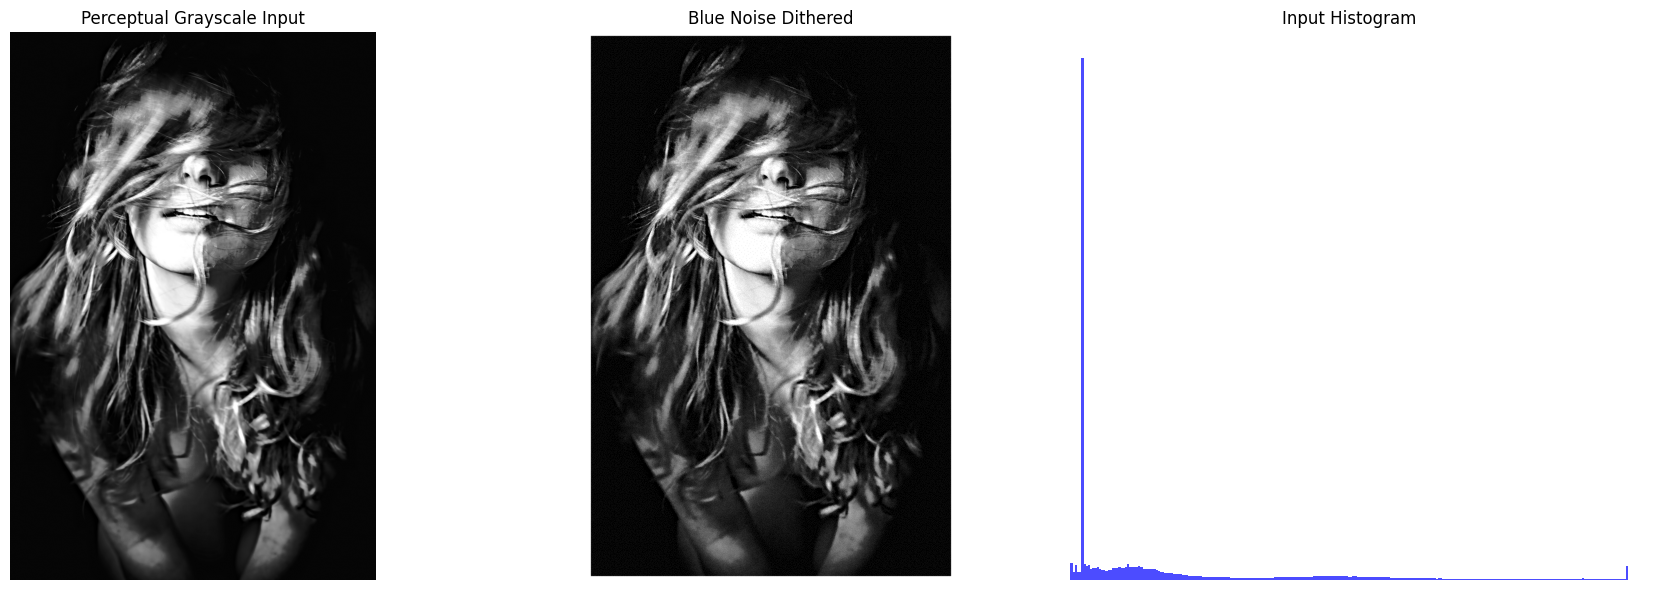

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageOps
import os

# ==========================================
# 2. Helper Functions
# ==========================================

def load_and_normalize(path):
    """Loads an image, converts to float, normalizes to 0-1."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    
    img = Image.open(path)
    img = img.convert('RGB') # Ensure RGB
    return np.array(img).astype(np.float32) / 255.0

def rgb_to_grayscale_perceptual(img_rgb):
    """
    Converts RGB to Grayscale using Rec. 601 Luma coefficients.
    L = 0.299*R + 0.587*G + 0.114*B
    """
    # img_rgb shape is (H, W, 3)
    r = img_rgb[:, :, 0]
    g = img_rgb[:, :, 1]
    b = img_rgb[:, :, 2]
    
    gray = 0.299 * r + 0.587 * g + 0.114 * b
    return gray

def tile_noise(noise_texture, target_shape):
    """
    Tiles the noise texture to cover the target image shape.
    target_shape: (Height, Width)
    """
    th, tw = target_shape
    nh, nw = noise_texture.shape
    
    # Calculate how many times to repeat in Y and X
    repeat_y = (th // nh) + 1
    repeat_x = (tw // nw) + 1
    
    # Tile and crop to exact size
    tiled = np.tile(noise_texture, (repeat_y, repeat_x))
    return tiled[:th, :tw]

def resize_to_physical_dim(pil_img, longest_edge_mm, dpi):
    target_pixels_max = int((longest_edge_mm / 25.4) * dpi)
    
    # FIX: Handle both PIL Images and NumPy Arrays
    if hasattr(pil_img, 'shape'):  # It's a NumPy array
        h, w = pil_img.shape[:2]   # shape is (Height, Width, Channels)
        is_numpy = True
    else:                          # It's a PIL Image
        w, h = pil_img.size        # size is (Width, Height)
        is_numpy = False
        
    # Calculate scale maintaining aspect ratio
    if w > h:
        scale = target_pixels_max / w
    else:
        scale = target_pixels_max / h
        
    new_w = int(w * scale)
    new_h = int(h * scale)

    # Perform resize
    if is_numpy:
        import cv2
        # OpenCV uses (width, height) for resize, but input was array
        return cv2.resize(pil_img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    else:
        return pil_img.resize((new_w, new_h), resample=Image.LANCZOS)

def scale_to_percentile_global(img_rgb, percentile=95):
   
    # Calculate the percentile value of the entire image
    white_point = np.percentile(img_rgb, percentile)
    
    # Scale and clip
    # Any pixel above the white_point becomes 255 (white)
    rescaled = (img_rgb / white_point) * 255
    rescaled = np.clip(rescaled, 0, 255).astype(np.uint8)
    
    return rescaled

# ==========================================
# 3. Main Logic
# ==========================================

try:
    # A. Load Input Image
    print(f"Loading image: {INPUT_IMAGE_PATH}")
    img_rgb = load_and_normalize(INPUT_IMAGE_PATH)
    img_rgb = scale_to_percentile_global((img_rgb * 255).astype(np.uint8), percentile).astype(np.float32) / 255.0
    img_rgb = resize_to_physical_dim(img_rgb, TARGET_LONGEST_EDGE_MM, target_image_dpi)
    
    # B. Convert to Grayscale Perceptually
    img_gray = rgb_to_grayscale_perceptual(img_rgb)
    print(f"Image Size: {img_gray.shape}")

    # C. Load Blue Noise Texture
    print(f"Loading noise: {BLUE_NOISE_PATH}")
    # Load noise, convert to grayscale (L), normalize 0-1
    noise_img = Image.open(BLUE_NOISE_PATH).convert('L')
    noise_arr = np.array(noise_img).astype(np.float32) / 255.0

    # D. Tile the Noise to match Image Size
    noise_tiled = tile_noise(noise_arr, img_gray.shape)

    #power_levels = np.array([0.0, 0.0, 0.8, 1.0], dtype=np.float32)

    # 2. Convert Image Brightness to Target Laser Power
    # Assuming img_gray: 1.0 = White (Paper), 0.0 = Black (Ink)
    # We invert this because for the laser: 0.0 = Off (Paper), 1.0 = On (Burn)
    target_power = img_gray

    #target_power = (target_power - target_power.min()) / (target_power.max() - target_power.min())

    # Ensure range is strictly 0-1
    target_power = np.clip(target_power, 0.0, 1.0)

    # 3. Find the Lower and Upper bounds for every pixel
    # We find which interval of power_levels the current pixel falls into.
    # np.searchsorted finds the insertion index to maintain order.
    # We subtract 1 to get the index of the "step below".
    idx = np.searchsorted(power_levels, target_power, side='right') - 1

    # Clamp indices to ensure we don't go out of bounds
    idx = np.clip(idx, 0, len(power_levels) - 2)

    lower_step = power_levels[idx]
    upper_step = power_levels[idx + 1]

    # 4. Normalize the pixel value within its specific step interval
    # Example: If pixel wants 0.7 power, it sits between 0.5 and 0.9.
    # The normalized value (0.0 to 1.0) represents how close it is to the upper step.
    step_range = upper_step - lower_step

    # Handle case where step_range is 0 to avoid division by zero
    step_range[step_range == 0] = 1.0 

    normalized_val = (target_power - lower_step) / step_range

    # 5. Apply the Blue Noise Threshold
    # If the normalized value is higher than the noise, bump up to the upper step.
    # Otherwise, stay at the lower step.
    step_up_mask = normalized_val > noise_tiled

    dithered_output = np.where(step_up_mask, upper_step, lower_step)

    runout_px = int((runout_mm / 25.4) * target_image_dpi)

    # FIX: Convert NumPy array to PIL Image
    # Ensure the array is uint8 (0-255) or bool before converting
    if isinstance(dithered_output, np.ndarray):
        # If your dithered output is float (0.0-1.0), scale to 255
        if dithered_output.max() <= 1.0:
            dithered_output = (dithered_output * 255).astype(np.uint8)
        
        dithered_output = Image.fromarray(dithered_output.astype(np.uint8))

    # Now this will work
    dithered_output = ImageOps.expand(dithered_output, border=runout_px, fill='white')

    # ==========================================
    # 4. Visualization
    # ==========================================
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Original Grayscale
    ax[0].imshow(img_gray, cmap='gray', vmin=0, vmax=1)
    ax[0].set_title("Perceptual Grayscale Input")
    ax[0].axis('off')

    # Dithered Result
    ax[1].imshow(dithered_output, cmap='gray', vmin=0, vmax=1)
    ax[1].set_title("Blue Noise Dithered")
    ax[1].axis('off')

    # The Noise Mask (Zoomed in snippet for visualization)
    ax[2].hist(img_gray.ravel(), bins=255, color='blue', alpha=0.7)
    ax[2].set_title("Input Histogram")
    ax[2].axis('off')



    plt.tight_layout()
    plt.show()

    # Optional: Save result
    dithered_output.save('post_dither.png')

except Exception as e:
    print(f"Error: {e}")
    print("Ensure 'xyz.png' exists and the blue noise path is correct.")

Top-Left Pixel Digital Value: 255
Top-Left Pixel Ink Density: 0.0000


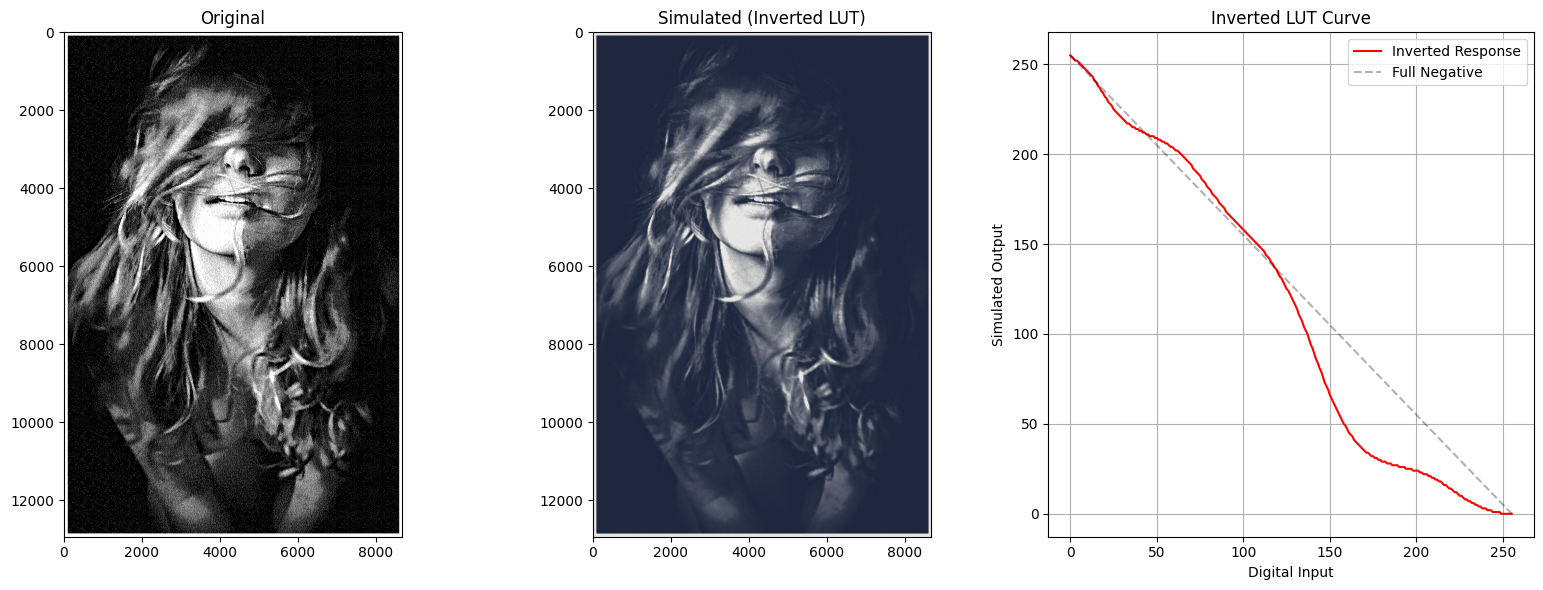

In [32]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_paper_texture(shape, scale=0.5, intensity=0.05):
    """Procedurally generates a watercolor paper texture (Aquarell)."""
    # Create random noise
    noise = np.random.normal(128, 20, (shape[0], shape[1])).astype(np.uint8)
    # Blur it to create "clumps" like paper pulp
    pulp = cv2.GaussianBlur(noise, (5, 5), 0)
    pulp = cv2.resize(pulp, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    pulp = pulp[:shape[0], :shape[1]]
    
    # Use Sobel to create a "bump map" effect (lighting from top-left)
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    edge_x = cv2.filter2D(pulp, -1, kernel_x)
    edge_y = cv2.filter2D(pulp, -1, kernel_y)
    
    texture = (edge_x + edge_y).astype(np.float32) * intensity
    return texture

def apply_print_simulation_alt(image_path, kernel_path, lut_csv_path, source_dpi=1200, target_dpi=300):
     # 1. Load Image
    img_in = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img_in is None: raise FileNotFoundError("Input image not found.")

    scale_factor_in = source_dpi / target_dpi
    img_newx =  int(round(img_in.shape[1] * scale_factor_in))
    img_newy =  int(round(img_in.shape[0] * scale_factor_in))
    img = cv2.resize(img_in, (img_newx, img_newy), interpolation=cv2.INTER_CUBIC)

    # --- ADDED: STRETCH INPUT VALUES TO 0-255 ---
    # This ensures the darkest pixel becomes 0 and the lightest becomes 255
    # before the LUT is applied.
    img_min, img_max = img.min(), img.max()
    if img_max > img_min:
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    # --------------------------------------------
    
    # 2. Fix the Inverted LUT Logic
    df_lut = pd.read_csv(lut_csv_path).sort_values(by='Input')
    all_inputs = np.arange(256)
    
    # We create the LUT from your CSV
    lut_raw = np.interp(all_inputs, df_lut['Input'], df_lut['Output'])
    
    # LOGIC CHECK: 
    # If the user sends a white pixel (255), we want 0 density.
    # If the user sends a black pixel (0), we want max density.
    # We force the LUT to be a "Digital-to-Ink" map where 255 digital = 0 ink.
    if lut_raw[255] > lut_raw[0]:
        # If 255 digital resulted in high output, we must flip it
        lut_map = 255 - lut_raw
    else:
        lut_map = lut_raw

    # Apply the mapping to get Ink Density (0.0 to 1.0)
    ink_density = cv2.LUT(img, lut_map.astype(np.uint8).reshape((1, 256))).astype(np.float32) / 255.0

    # 3. Handle Kernel (Spatial Spread)
    kernel_1200 = np.load(kernel_path).astype(np.float32)
    kernel_1200 /= (kernel_1200.sum() + 1e-8)
    
    # scale = target_dpi / source_dpi
    # k_size = int(round(kernel_1200.shape[0] * scale))
    # if k_size % 2 == 0: k_size += 1
    # kernel_scaled = cv2.resize(kernel_1200, (k_size, k_size), interpolation=cv2.INTER_AREA)
    # kernel_scaled /= (kernel_scaled.sum() + 1e-8)

    # Spread the ink
    spread_density = cv2.filter2D(ink_density, -1, kernel_1200)

    # 4. Subtractive Overlap (Capping)
    k_val = 2.5 
    saturated_density = 1.0 - np.exp(-k_val * spread_density)
    saturated_density = np.clip(saturated_density, 0, 1)

    # 5. Final RGB Color Mapping
    PAPER_WHITE = np.array([235, 241, 243]) # BGR (flipped from your original)
    # Indigo: Dark Blue
    INDIGO_DARK = np.array([45, 20, 10]) # BGR (flipped from your original)
    
    h, w = saturated_density.shape
    sim_rgb = np.zeros((h, w, 3), dtype=np.float32)
    
    for i in range(3):
        # 0.0 Density = Paper Color
        # 1.0 Density = Indigo Color
        sim_rgb[:,:,i] = (1.0 - saturated_density) * PAPER_WHITE[i] + (saturated_density) * INDIGO_DARK[i]

    # 6. Add Texture
    grain = np.random.normal(0, 1.2, (h, w))
    for i in range(3): sim_rgb[:,:,i] += grain

    # Debug: Confirm inversion is correct
    # Corner pixels in digital images are usually background (White/255)
    # They should have near-zero density.
    print(f"Top-Left Pixel Digital Value: {img[0,0]}")
    print(f"Top-Left Pixel Ink Density: {ink_density[0,0]:.4f}")

    sim_rgb = cv2.resize(sim_rgb,(int(round(img.shape[1])), int(round(img.shape[0]))), interpolation=cv2.INTER_AREA)
    return img,np.clip(sim_rgb, 0, 255).astype(np.uint8), lut_map


original, simulated, inverted_lut = apply_print_simulation_alt(
    post_img_path, 
    kernel_file, 
    lut_file,
    source_dpi=kernel_source_dpi,
    target_dpi=target_image_dpi # Adjust to your digital image resolution
)

#simulated = cv2.LUT(simulated, inverted_lut)    
simulated = simulated.astype(np.float32) / 255.0
#simulated = np.power(simulated, 1.4)
simulated = np.clip(simulated * 255.0, 0, 230).astype(np.uint8)
cv2.imwrite('simulated_paper_conv.png', simulated)
# --- Visualization ---
plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 2)
plt.title("Simulated (Inverted LUT)")
plt.imshow(cv2.cvtColor(simulated, cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 3)
plt.title("Inverted LUT Curve")
plt.plot(inverted_lut, color='red', label='Inverted Response')
plt.plot([0, 255], [255, 0], 'k--', alpha=0.3, label='Full Negative')
plt.xlabel('Digital Input')
plt.ylabel('Simulated Output')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
plt.show()

